# Hunting Jordan Peterson's angry mob

As online communities have gained traction in the 'real world', journalists have worked to understand and explain them. So far, their attempts have come up short. Nowhere has this been more evident than in the critical news coverage of Jordan Peterson's rise to international fame — he's been called the world's most influential public intellectual. 

But opinion about him are polarized. Peterson's detractors see him as a dangerously regressive influence, perpetuating bigotry and provoking violence. In stark contrast, his supporters are a devoted online community. With over 1 million subscribers on his YouTube channel — which primarily features his university lectures — Peterson's viewers eagerly support his work. As of this writing, he has nearly 9,500 patrons on Patreon (each of these people is happily donating at least $1 per month).

What explains the divide?

In 2016, Peterson stepped into the culture war, sparking a global political controversy that launched him into mainstream media coverage. After Canada's parliament passed Bill C-16, which added transgender people as a protected class under Canada's human rights code, [Peterson argued](https://www.youtube.com/playlist?list=PL22J3VaeABQD8oW-mqWpKumeqglQCe6VZ) that the new law compelled people to use certain pronouns — a violation of free speech. Between this and his sharp criticisms of identity politics, Peterson raised the ire of the political left.

Naturally, criticism followed the spotlight.  [Many](https://www.theguardian.com/media/2018/mar/19/cathy-newman-the-internet-is-being-written-by-men-with-an-agenda) [mainstream](https://www.independent.co.uk/voices/cathy-newman-abuse-channel-4-jordan-peterson-metoo-backlash-latest-a8170031.html) [articles](https://www.macleans.ca/opinion/is-jordan-peterson-the-stupid-mans-smart-person/) [have](https://www.nybooks.com/daily/2018/03/19/jordan-peterson-and-fascist-mysticism/) [categorized](https://jacobinmag.com/2018/02/jordan-peterson-enlightenment-nietzsche-alt-right) Dr. Peterson as a backwards misogynist, backed by an online horde of _angry white men_ who spit vitriol at anyone who dares to debate him.

As a member of Peterson's audience, this contradicts my observations. While Tweets and YouTube comments are rarely high-brow, his audience seems normal (or better) to me. I also attended one of his lectures in New York and saw a curious and eager group of mostly young professionals — not screaming skinheads nor embittered incels. My impressions, however, could have been clouded by my biases.

Perhaps the journalists above know something I don't. Perhaps they're more biased than we realize. If we simply rely on our gut reactions to a handful of comments, however, we'll never be able to grasp what online communities of millions think. We need high resolution tools to understand this question, not emotional heuristics. We're going to use solid data to analyze the claims of these journalists.

To carry out our analysis, we'll scrape the comments from a few dozen YouTube videos — some involving Jordan Peterson, others without the controversial professor; some on intellectual topics, others from pop culture. Then, we'll perform semantic analysis on the comments. We can test polarity, which shows whether the tone is positive or negative, and mood, which (as you may expect) tells us which moods are expressed by a word.

By the end, we will be able to prove (or falsify) the claim that Jordan Peterson's audience is abnormally negative and angry towards those who disagree with him. Let's start by pulling in our datasets.

### Data Preparation

In [1]:
import pandas as pd
import numpy as np

# Grab metadata from a JSON file and add it to a dataframe
metadataframe = pd.read_json('./comment-assets/comment-directory.json')
metadataframe.head() # display first few fows

,Debate,Genre,JBP,Path,Video Title
0,True,Intellectual,True,./comment-assets/newman-new.csv,Peterson vs Newman
1,False,Intellectual,True,./comment-assets/biblical-lectures.csv,Biblical Lectures (Peterson)
2,True,Intellectual,True,./comment-assets/munk-debate.csv,"Munk Debate (Peterson, Fry, Dyson, Goldberg)"
3,False,Intellectual,True,./comment-assets/personality-lectures.csv,Personality Lectures (Peterson)
4,False,Intellectual,True,./comment-assets/peterson-rogan.csv,Peterson on Rogan


We're looking at scraped comments from various YouTube videos:
- Jordan Peterson's [Cathy Newman interview](https://www.youtube.com/watch?v=aMcjxSThD54)
- All of Peterson's lectures on the [Psychological Significance of the Biblical Stories](https://www.youtube.com/watch?v=f-wWBGo6a2w&list=PL22J3VaeABQD_IZs7y60I3lUrrFTzkpat), combined into one file
- All of Peterson's Personality lectures from [2017](https://www.youtube.com/watch?v=kYYJlNbV1OM&list=PL22J3VaeABQApSdW8X71Ihe34eKN6XhCi) and [2016](https://www.youtube.com/watch?v=UGLsnu5RLe8&list=PL22J3VaeABQAOhH1CLMNnMl2R-O1abW1T), combined into one file
- The [Munk Debate](https://www.youtube.com/watch?v=GxYimeaoea0) featuring Jordan Peterson, Stephen Fry versus Michael Eric Dyson and Michelle Goldberg
- Two presidential debates: [Clinton versus Trump](https://www.youtube.com/watch?v=855Am6ovK7s) and [Obama versus Romney](https://www.youtube.com/watch?v=QEpCrcMF5Ps)
- The first PewDiePie [video](https://www.youtube.com/watch?v=VOochquOIoo) I found on his channel
- Music videos by [The Chainsmokers](https://www.youtube.com/watch?v=nuckTcoZG4Q), [Drake](https://www.youtube.com/watch?v=U9BwWKXjVaI), and [Metallica](https://www.youtube.com/watch?v=tAGnKpE4NCI)
- A [makeup](https://www.youtube.com/watch?v=GJ9_7L873m8) video
- Four TED Talks on various topics [1](https://www.youtube.com/watch?v=8nt3edWLgIg) [2](https://www.youtube.com/watch?v=_QdPW8JrYzQ) [3](https://www.youtube.com/watch?v=KM4Xe6Dlp0Y&t=5s) [4](https://www.youtube.com/watch?v=Ks-_Mh1QhMc&t=4s)
- Jordan Peterson's appearance on [Real Time](https://www.youtube.com/watch?v=8wLCmDtCDAM) with Bill Maher, which got a little testy
- Jordan Peterson's [second appearance](https://www.youtube.com/watch?v=USg3NR76XpQ) on the Joe Rogan podcast
- [Christopher Hitchens debating Tariq Ramadan](https://www.youtube.com/watch?v=_CGFMwtJTyE) about whether Islam is a religion of peace

We're also tracking their genres, whether a video is a debate, and whether it contains Jordan Peterson. Now let's load in all of our comments.

In [2]:
comments = pd.DataFrame()

# Build a comments dataframe by pulling data from files listed in the metadata entered above
for idx, video in metadataframe.iterrows():
    df = pd.read_csv(video['Path'], error_bad_lines=False)
    df['Video Title'] = video['Video Title']
    df['JBP'] = video['JBP']
    df['Debate'] = video['Debate']
    df['Genre'] = video['Genre']
    comments = comments.append(df, ignore_index=True)

print(len(comments), 'comments added.')

b'Skipping line 675: expected 4 fields, saw 7\nSkipping line 1349: expected 4 fields, saw 7\nSkipping line 2003: expected 4 fields, saw 7\nSkipping line 3086: expected 4 fields, saw 7\nSkipping line 3512: expected 4 fields, saw 7\nSkipping line 4132: expected 4 fields, saw 7\nSkipping line 4676: expected 4 fields, saw 7\nSkipping line 5468: expected 4 fields, saw 7\nSkipping line 6616: expected 4 fields, saw 7\nSkipping line 7912: expected 4 fields, saw 7\nSkipping line 8580: expected 4 fields, saw 7\nSkipping line 9316: expected 4 fields, saw 7\nSkipping line 12769: expected 4 fields, saw 7\nSkipping line 13225: expected 4 fields, saw 7\nSkipping line 14557: expected 4 fields, saw 7\nSkipping line 15291: expected 4 fields, saw 7\n'
b'Skipping line 146: expected 4 fields, saw 7\nSkipping line 674: expected 4 fields, saw 7\nSkipping line 704: expected 4 fields, saw 7\nSkipping line 1138: expected 4 fields, saw 7\nSkipping line 1214: expected 4 fields, saw 7\nSkipping line 1420: expected

294036 comments added.


Next, we're going to build functions to perform semantic analysis on these comments. To start, we'll clean the data by removing punctuation, splitting comments into lists of individual words (tokenizing), and dropping stopwords such as "the", "this", and "and".

In [3]:
import re, string

def comment_cleaner(df):
    clean_comments = []    
    punct = str.maketrans(string.punctuation,' '*len(string.punctuation))
    for idx, comment in df.iterrows():
        cleaned = str(comment['commentText']).translate(punct)
        clean_comments.append(cleaned.lower().replace('\n', ' ').replace('\r', '').split(' '))
    return pd.Series(clean_comments)

In [4]:
# Use spaCy's natural language processing tools to identify stopwords
import spacy
nlp = spacy.load('en')

def remove_stopwords(column):
    for comment in column:
        comment[:] = [x for x in comment if not nlp.vocab[str(x)].is_stop]
    return column

After scrubbing out all of our unnecessary stopwords and punctuation, we can use SenticNet to get the _polarity_ of each comment. Polarity tells us whether the tone of a comment is positive, negative, or neutral. Here's a brief example:

In [5]:
from senticnet.senticnet import SenticNet
sn = SenticNet()

print('Good polarity: ', sn.polarity_intense('good'))
print('Love polarity: ', sn.polarity_intense('love'))
print('Hate polarity: ', sn.polarity_intense('hate'))
print('Evil polarity: ', sn.polarity_intense('evil'))
print('Beef polarity: ', sn.polarity_intense('beef')) # Should be near, but not equal to, 0

Good polarity:  0.849
Love polarity:  0.83
Hate polarity:  -0.83
Evil polarity:  -0.76
Beef polarity:  0.083


The function below takes a comment as a parameter and finds the polarity of each word in the comment. Then, it takes the mean of all nonzero polarities — polarities of 0.0 are typically triggered by typos or proper nouns, which we do not want to skew our average.

The complete set of comment polarity scores will allow us to see the full distribution of commenters' tones.

In [6]:
def get_polarity(comment):
    comment_polarity = []
    for word in comment:
        token_polarity = 0.0
        try:
            token_polarity = float(sn.polarity_intense(str(word)))
        except Exception as e:
            pass
        comment_polarity.append(token_polarity)
    return np.mean([item for item in comment_polarity if (item != 0)])

To get more granular than mere positive-versus-negative, we're going to use SenticNet's _moodtags_: 'admiration', 'interest', 'joy', 'surprise', 'anger', 'sadness', 'fear', and 'disgust'. Each word analyzed will generate two moodtags, and each comment will have its own list of all of the moodtags generated.

In [7]:
print('Good moodtags: ', sn.moodtags('good'))
print('Love moodtags: ', sn.moodtags('love'))
print('Hate moodtags: ', sn.moodtags('hate'))
print('Evil moodtags: ', sn.moodtags('evil'))
print('Beef moodtags: ', sn.moodtags('beef'))

Good moodtags:  ['#joy', '#interest']
Love moodtags:  ['#joy', '#admiration']
Hate moodtags:  ['#anger', '#disgust']
Evil moodtags:  ['#fear', '#disgust']
Beef moodtags:  ['#interest', '#interest']


Later on, we will use this data to visualize the prevalence of certain moods (such as anger) among Jordan Peterson's commenters compared to commenters among other YouTube populations.

The following function assigns a list of moodtags to each comment in the dataframe.

In [8]:
def get_moodtags(comment):
    comment_moods = []
    for word in comment:
        try:
            comment_moods.append(sn.moodtags(str(word)))
        except Exception as e:
            pass
    return [item.strip('#') for sublist in comment_moods for item in sublist]

Let's run all of the comments through these functions.

In [9]:
comments['Cleaned'] = remove_stopwords(comment_cleaner(comments))
comments['Polarity'] = comments['Cleaned'].apply(get_polarity)
comments['Moodtags'] = comments['Cleaned'].apply(get_moodtags)
print(len(comments), 'comments processed.')

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


294036 comments processed.


Everything is ready to go. Let's get started with our analysis.

### Statistical Tests

Each of these comment groupings has a distribution of polarities. We're going to run the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test) to check if these distributions are significantly different.  Essentially, KS tests the null hypothesis that two independent samples are drawn from the same distribution. A high KS statistic or low p-value would allow us to reject the null hypothesis.

In [10]:
import scipy
from scipy import stats

# Comparing Peterson's Newman interview to itself
newman_interview = comments.loc[(comments['Video Title']=='Peterson vs Newman')]
print('Baseline:', scipy.stats.ks_2samp(comments.loc[comments['Video Title']=='Peterson vs Newman']['Polarity'], newman_interview['Polarity']))

Baseline: Ks_2sampResult(statistic=0.0, pvalue=1.0)


The null hypothesis will show a _p-value_ of 1.0 and a statistic of 0.0. What do some real examples show?

In [11]:
peterson_debates = comments.loc[(comments['JBP']==True) & (comments['Debate']==True)]
intellectual_debates_sans_peterson = comments.loc[(comments['Debate']==True) & (comments['JBP']==False) & (comments['Genre']=='Intellectual')]

# Comparing Peterson's Newman interview with his other debates
print(scipy.stats.ks_2samp(newman_interview['Polarity'], comments.loc[(comments['JBP']==True) & (comments['Video Title']!='Peterson vs Newman')]['Polarity']))

# Comparing all Jordan Peterson videos to all others
print(scipy.stats.ks_2samp(comments.loc[(comments['JBP']==True)]['Polarity'], comments.loc[(comments['JBP']==False)]['Polarity']))

# Comparing all Jordan Peterson debates with other debates
print(scipy.stats.ks_2samp(intellectual_debates_sans_peterson['Polarity'], peterson_debates['Polarity']))

Ks_2sampResult(statistic=0.05948874379722463, pvalue=5.698073473652533e-96)
Ks_2sampResult(statistic=0.19655750279728734, pvalue=0.0)
Ks_2sampResult(statistic=0.1098267413417417, pvalue=4.925503926430389e-237)


Across categories, we see significant differences in the polarity distributions — our first two p-values are well below 0.01 (note the scientific notation). We know these samples aren't drawn from the same distribution.

Next, we'll generate similarity scores for every comment set. We're looking to see which sets of comments are most similar (or different) and hoping to find a pattern. Step 1: build a [probability density function](https://en.wikipedia.org/wiki/Probability_density_function) for each set of comments, so our comparisons aren't skewed by the amount of comments per video.

In [12]:
polarity_dataframe = pd.DataFrame()
bins = 100

# Split the distribution for each set of comments' polarities into 100 bins
for title in comments['Video Title'].unique():
    pol = comments.loc[comments['Video Title']==title]['Polarity']
    hist = np.histogram(pol.dropna(), bins=bins)
    polarity_dataframe[title] = hist[0]

# Divide each row by the sum of the entire column, then save the dataframe
beta = polarity_dataframe.sum(axis=0)
polarity_dataframe = polarity_dataframe.apply(lambda row: row / beta, axis=1)

Now let's build a new dataframe that will allow us to do a pairwise comparison of each video to every other video.

In [13]:
column_headers = list(polarity_dataframe)
pairwise_list = []

# Nested loops round-robin through our columns, creating a pairwise comparison
for i in range(len(column_headers)):
    for j in range(i+1, len(column_headers)):
        pairwise_list.append({'Video 1': column_headers[i], 'Video 2': column_headers[j]})

# Create new dataframe from list of dicts
pairwise_comparison = pd.DataFrame(pairwise_list)

Now that we have our pairwise comparisons set up, let's run some similarity scores: Euclidean Distance, Manhattan Distance, and Cosine Similarity. We'll add each of those to the dataframe, and then sort them in that order.

In [14]:
from tools.similarityscores import Similarity
similarity = Similarity()

euclidean_distance = []
manhattan_distance = []
cosine_similarity = []

# Build lists of similarity scores for each pairwise comparison
for idx, row in pairwise_comparison.iterrows():
    vid1 = polarity_dataframe[row['Video 1']]
    vid2 = polarity_dataframe[row['Video 2']]
    euclidean_distance.append(similarity.euclidean_distance(vid1, vid2))
    manhattan_distance.append(similarity.manhattan_distance(vid1, vid2))
    cosine_similarity.append(similarity.cosine_similarity(vid1, vid2))

# Add columns from each list of similarity scores
pairwise_comparison['Euclidean Distance'] = euclidean_distance
pairwise_comparison['Manhattan Distance'] = manhattan_distance
pairwise_comparison['Cosine Similarity'] = cosine_similarity

pairwise_comparison.sort_values(by=['Euclidean Distance', 'Manhattan Distance',
                                    'Cosine Similarity'], ascending=[True, True, False])

,Video 1,Video 2,Euclidean Distance,Manhattan Distance,Cosine Similarity
57,Personality Lectures (Peterson),TED Talk Cameron Russell,0.020996,0.144837,0.993
35,"Munk Debate (Peterson, Fry, Dyson, Goldberg)",Peterson on Maher,0.021835,0.137678,0.992
18,Biblical Lectures (Peterson),Personality Lectures (Peterson),0.023899,0.150416,0.990
1,Peterson vs Newman,"Munk Debate (Peterson, Fry, Dyson, Goldberg)",0.024205,0.184197,0.983
28,Biblical Lectures (Peterson),TED Talk Cameron Russell,0.024470,0.171548,0.991
70,Peterson on Rogan,TED Talk Cameron Russell,0.024472,0.164843,0.990
48,Personality Lectures (Peterson),Peterson on Rogan,0.024681,0.154235,0.990
19,Biblical Lectures (Peterson),Peterson on Rogan,0.028806,0.193063,0.986
26,Biblical Lectures (Peterson),TED Talk Sam Harris,0.029629,0.201150,0.979
9,Peterson vs Newman,Hitchens vs Ramadan Debate,0.032581,0.224609,0.976


All of this makes intuitive sense. We're seeing pairings fall neatly into the genres of _intellectual_ versus _popular_, as well as intellectual's subgenres of _debate_ or _lecture/talk_. 

The most similar sets of comments are on Jordan Peterson's two most famous and acrimonious debates. The top group includes various pairings of intellectual lectures and debates. On the most-different end, we see presidential debates athwart music videos and PewDiePie looking quite different from Jordan Peterson's appearance on Real Time with Bill Maher.

Notably, we're not seeing a major difference (or lack of similarity) between Jordan Peterson's audience and other intellectual audiences — in fact, many of the most-similar comment sets are between Peterson's audience and TED Talks, major debates, and presidential debates.

Let's drill down on the similarity scores for the Cathy Newman interview to illustrate the point.

In [15]:
pairwise_comparison.loc[pairwise_comparison['Video 1']=='Peterson vs Newman'].sort_values(by=['Euclidean Distance', 'Manhattan Distance',
                                    'Cosine Similarity'], ascending=[True, True, False])

,Video 1,Video 2,Euclidean Distance,Manhattan Distance,Cosine Similarity
1,Peterson vs Newman,"Munk Debate (Peterson, Fry, Dyson, Goldberg)",0.024205,0.184197,0.983
9,Peterson vs Newman,Hitchens vs Ramadan Debate,0.032581,0.224609,0.976
12,Peterson vs Newman,TED Talk Cameron Russell,0.033990,0.275404,0.968
4,Peterson vs Newman,Peterson on Maher,0.034375,0.237079,0.974
2,Peterson vs Newman,Personality Lectures (Peterson),0.035778,0.291276,0.965
3,Peterson vs Newman,Peterson on Rogan,0.038748,0.314713,0.959
0,Peterson vs Newman,Biblical Lectures (Peterson),0.045026,0.351860,0.949
7,Peterson vs Newman,Clinton vs Trump Debate,0.046750,0.259768,0.935
13,Peterson vs Newman,TED Talk Amy Cuddy,0.055291,0.408984,0.913
16,Peterson vs Newman,Drake Music Video,0.056506,0.376446,0.908


As you can see from these two tables, early indications show that comment tone depends more on video type than any particular YouTuber's audience. Let's visualize some of these comparisons to get a better sense of how different audiences and genres relate.

### Comparing by Genre

In [16]:
import matplotlib.pyplot as plt

plt.hist(comments.loc[(comments['Debate']==True) & (comments['JBP']==False)]['Polarity'].dropna(), normed=True, color='blue', bins=100, alpha=.5, range=(-1, 1), label='Others')
plt.hist(comments.loc[(comments['Debate']==True) & (comments['JBP']==True)]['Polarity'].dropna(), normed=True, color='red', bins=100, alpha=.5, range=(-1, 1), label='Jordan Peterson')
plt.ylabel('Comments')
plt.xlabel('Polarities')
plt.title('Debates with Peterson vs Debates without')
plt.legend()
plt.show()

Both have similar shapes. Now let's look at all intellectual debates versus all intellectual lectures.

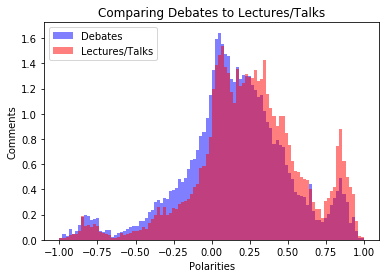

In [17]:
plt.hist(comments.loc[(comments['Genre']=='Intellectual') & (comments['Debate']==True)]['Polarity'].dropna(), normed=True, color='blue', bins=100, alpha=.5, range=(-1, 1), label='Debates')
plt.hist(comments.loc[(comments['Genre']=='Intellectual') & (comments['Debate']==False)]['Polarity'].dropna(), normed=True, color='red', bins=100, alpha=.5, range=(-1, 1), label='Lectures/Talks')
plt.ylabel('Comments')
plt.xlabel('Polarities')
plt.title('Comparing Debates to Lectures/Talks')
plt.legend()
plt.show()

Again, the curves share a similar shape. Now, let's take a look at Peterson's lectures versus non-Peterson lectures (our TED talks):

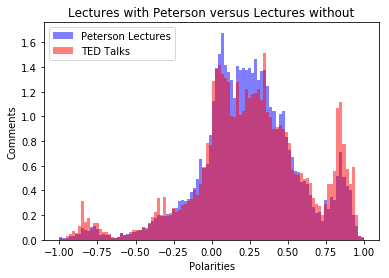

In [18]:
plt.hist(comments.loc[(comments['Genre']=='Intellectual') & (comments['Debate']==False) & (comments['JBP']==True)]['Polarity'].dropna(), normed=True, color='blue', bins=100, alpha=.5, range=(-1, 1), label='Peterson Lectures')
plt.hist(comments.loc[(comments['Genre']=='Intellectual') & (comments['Debate']==False) & (comments['JBP']==False)]['Polarity'].dropna(), normed=True, color='red', bins=100, alpha=.5, range=(-1, 1), label='TED Talks')
plt.ylabel('Comments')
plt.xlabel('Polarities')
plt.title('Lectures with Peterson versus Lectures without')
plt.legend()
plt.show()

From these, we can see that Peterson's audience is highly similar in tone to other audiences in the same genre. To firm up our genre hypothesis, let's compare overall intellectual videos to popular videos to visualize why those were splitting so dramatically in the similarity scoring.

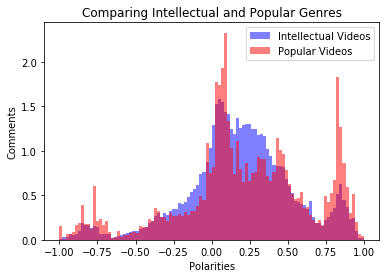

In [19]:
plt.hist(comments.loc[(comments['Genre']=='Intellectual')]['Polarity'].dropna(), normed=True, color='blue', bins=100, alpha=.5, range=(-1, 1), label='Intellectual Videos')
plt.hist(comments.loc[(comments['Genre']=='Popular')]['Polarity'].dropna(), normed=True, color='red', bins=100, alpha=.5, range=(-1, 1), label='Popular Videos')
plt.ylabel('Comments')
plt.xlabel('Polarities')
plt.title('Comparing Intellectual and Popular Genres')
plt.legend()
plt.show()

Clearly, differences between genre form the biggest split between audiences' tones in the comments.

### Audience Mood

Now that we've addressed tone and shown that Jordan Peterson's audience isn't abnormally negative (or abnormally _anything_, for that matter), let's move into SenticNet's moodtags to see if we can find some abnormalities there. Specifically, we're investigating the claim that Peterson's audience has an overrepresentation of negative moods — particularly anger — in Peterson's debates with others.

Pie charts are the simplest way to visualize a count of all of our moodtags. Let's get started.

In [20]:
from collections import Counter

# Setting up our pie charts for visual consistency
explode = (0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 0.1)
labels = ['admiration', 'interest', 'joy', 'surprise', 'anger', 'sadness', 'fear', 'disgust']

# Creating a Counter object to count (duh) every moodtag in a given set of comments
def count_moodtags(df):
    word_string = ''
    word_list = [item for sublist in df['Moodtags'] for item in sublist]
    word_string += ', '.join(word_list)
    return Counter(word_list)

First, let's take a broad look at the combined comments on all of Jordan Peterson's videos:

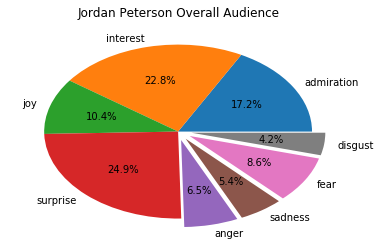

In [21]:
plt.pie(count_moodtags(comments.loc[comments['JBP']==True]).values(), labels=labels, autopct='%1.1f%%', explode=explode)
plt.title('Jordan Peterson Overall Audience')
plt.show()

Right out, this is not an angry group of people. Let's drill down and see if we can find where that 6.5% anger is coming from. Perhaps it's overrepresented in Peterson's interview with Cathy Newman on Channel 4; after all, this is the video where the "Peterson's fans are an angry mob" narrative emerged. Channel 4 claimed that the deluge of negative and threatening comments was so severe, they needed to bring in security experts.

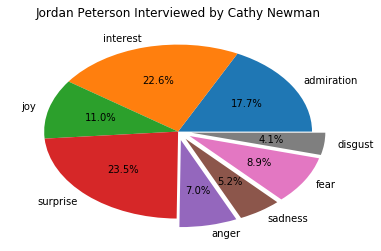

In [22]:
plt.pie(count_moodtags(comments.loc[comments['Video Title']=='Peterson vs Newman']).values(), labels=labels, autopct='%1.1f%%', explode=explode)
plt.title('Jordan Peterson Interviewed by Cathy Newman')
plt.show()

Surprisingly, everything is right near the baseline. According to the data, this is not an angry mob. Let's move our comparison to overall debates and see if the response to all of his debates is different:

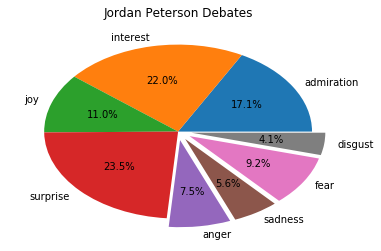

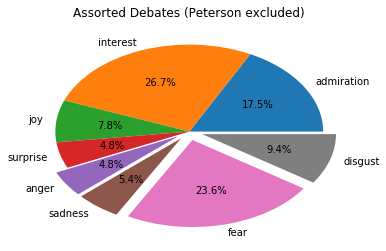

In [23]:
plt.figure(0)
plt.pie(count_moodtags(comments.loc[(comments['Debate']==True) & comments['JBP']==True]).values(), labels=labels, autopct='%1.1f%%', explode=explode)
plt.title('Jordan Peterson Debates')

plt.figure(1)
plt.pie(count_moodtags(comments.loc[(comments['Debate']==True) & (comments['JBP']==False)]).values(), labels=labels, autopct='%1.1f%%', explode=explode)
plt.title('Assorted Debates (Peterson excluded)')

plt.show()

For the Peterson debates, the anger level is right near the baseline. We've found clear evidene contradicting the narrative that Peterson's audience angrily hounds anyone who argues with him.

This reveals a key problem with how journalists have approached online communities. Though we see a mere 7% anger, that's drawn from hundreds of thousands of comments. If you were scrolling for a few minutes, you might happen on these and perceive a lot of anger.

But immediate perceptions are not always accurate representations of reality — we're easily fooled by biases and constrained by limited perspective. Conversations involving millions of people are brand-new, so tools far beyond gut reactions and nitpicked quotes to understand them.

For example, my bias leads me to _expect_ that Peterson's audience would behave well around debates. After all, one of Jordan Peterson's biggest claims to fame is his support of free speech and open debate. He has hours of video on his YouTube channel dedicated to the importance of vigorous argument. Remembering that, perhaps it shouldn't be so surprising that Peterson's audience actually seems _far more calm and comfortable_ around debates than other audiences.

The general audience, oddly, is highly weighted towards fear — it makes up the second-largest mood category. My hunch is that it's skewed by the recent presidential debate between Trump and Clinton, so let's make sure we're not chasing an outlier.

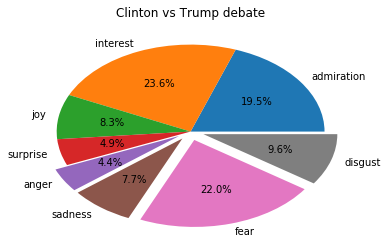

In [24]:
plt.pie(count_moodtags(comments.loc[(comments['Video Title']=='Clinton vs Trump Debate')]).values(), labels=labels, autopct='%1.1f%%', explode=explode)
plt.title('Clinton vs Trump debate')
plt.show()

Wow. It's below the fear baseline for all non-Peterson intellectual debates within our dataset.

While this is strange, it raises some questions for future analysis. Perhaps tone doesn't vary by video content or creator, but mood can vary drastically depending on what's in a given video. It might even vary widely _within_ a certain creator's audience; I've certainly seen audiences turn on creators when, for example, they "sell out" for sponsored content.

Let's move onwards to the audience for lectures and talks, since we've found a divergence in mood _within a genre_.

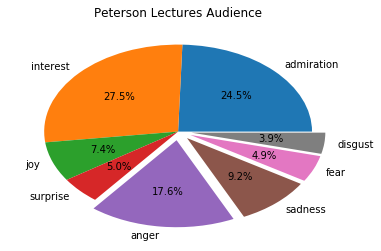

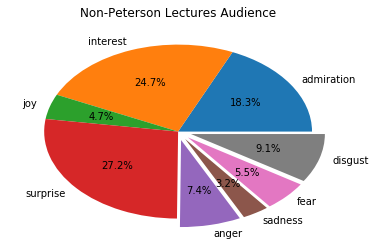

In [25]:
plt.figure(0)
plt.pie(count_moodtags(comments.loc[(comments['Genre']=='Intellectual') & (comments['Debate']==False)]).values(), labels=labels, autopct='%1.1f%%', explode=explode)
plt.title('Peterson Lectures Audience')

plt.figure(1)
plt.pie(count_moodtags(comments.loc[(comments['Genre']=='Intellectual') & (comments['Debate']==False) & (comments['JBP']==False)]).values(), labels=labels, autopct='%1.1f%%', explode=explode)
plt.title('Non-Peterson Lectures Audience')
plt.show()

We've found the angriest segment of Jordan Peterson's audience, and oddly, the comments are directed at 60-120 minute university lectures about psychology and philosophy. Anger is still a minority mood, but it's more than double the baseline for Peterson's overall audience.

Further, Peterson is the only person in the videos for the audience to be angry at; we're not looking at the hypothetical angry mob pursuing Peterson's debate opponents. Like the overrepresentation of fear in the debates above, this only raises new questions. We've found a path for further analysis for how different content might provoke different reactions _within a specific YouTube audience_.

### What we've found (and why)
Let's sum up our findings:
- The tone of a video's comments depends more on the video's genre and type than the specific YouTuber's audience.
- Peterson's commenters were consistent in tone with our other intellectual genre videos, and their subtypes: lectures and debates.
- Audience mood can vary more within an audience, but on an overall basis, Jordan Peterson's audience does not have an overrepresentation of anger.
- Specifically among debates, Jordan Peterson's audience actually has less negative moods than a general debate audience.

All of this brings us to our conclusion: Jordan Peterson's audience is neither abnormally negative nor abnormally angry towards people who disagree with him. The journalists who wrote with such certitude in the articles linked above were incorrect. But why?

Peterson's detractors are primarily political commentators — they're trained in analyzing mass political movements, and they are applying the same framework to interpret an online community. At a glance, these two groupings might seem similar: both can consist of millions of people, united by some common thread and therefore all doing something together.

A rally and an online community, however, are profoundly different. The rally is a simple creature: everyone attending supports some stated mission, and they show that support in a singular way — marching.

Online communities, however, present a massively more complex problem. Rather than marching as one behind the banner of a cause, online communities are decentralized and spontaneous. As a 'member' — if that label even applies — you are individual with your own voice. You attend if and when you please, engage in whichever way you see fit, and are not required to march in anyone's parade. The fractious diversity and subtle detail of the views in such a community cannot be reduced to a political platform — that model is far too low-resolution.

Compound that with the leftist political lens Peterson's detractors view the world through: a standard Marxist interpretation of Peterson's message would classify it as reactionary against the advances of modern 'intersectional' feminism. They then see that Peterson attracts white men. They infer that, since it is a reactionary movement of white men, that these men are struggling back against the social gains of other classes — and are therefore angry.

Then, they see angry comments on YouTube and Twitter, their ideological suppositions are confirmed, their blogs are drafted, and then their hot takes are broadcast to the world.

But now we know that we don't need to settle for hot takes about our online communities. As millions of people rapidly filter into these new social units, journalists need an interpretive framework to understand how masses of individuals interact on the internet. Let this be the first small step in that direction.